# Treinamento do modelo preditivo

Para treinar o modelo utilizei as seguintes bibliotecas

- **numpy** e **pandas** para manipulação dos dados
- **matplotlib** e **plotly** para visualização visualização dos resultados
- **sklearn** para preprocessamento, divisão dos dados em treinamento, validação e teste, e avaliação do modelo
- **xgboost** para instanciar o modelo preditivo

In [1]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor

# Declaração das funções para leitura dos dados

As funções estão duplicadas no notebook que usei para fazer as análises exploratórias.

In [2]:
def read_broadband():
    broadband = pd.read_csv('datasets/broadband_data.csv', sep=';')
    broadband.rename(columns={
        'error_range_(mae)(+/-)': 'error_range_mae',
        'error_range_(95%)(+/-)': 'error_range_95'
    }, inplace=True)

    for column in ['broadband_usage', 'error_range_mae', 'error_range_95',	'msd']:
        broadband[column] = broadband[column].str.replace(',', '.').astype('float64')
    # Converte county_id em string e prefixa '0' nos ids com 4 caracteres
    broadband.county_id = broadband.county_id.apply('{:0>5}'.format)
    # Remove county_ids de condatos equivalentes (Alguns CEPs estavam duplicados)
    broadband.drop(broadband[broadband.county_id.isin(['02158', '46102', '27111', '27163'])].index, inplace=True)
    
    return broadband


def read_county_population_density_per_square_mile():
    population_density = pd.read_csv('datasets/density-per-square-mile.csv', sep=',')
    population_density.rename(columns={
        'GCT_STUB.target-geo-id2': 'county_id',
        'Density per square mile of land area': 'density_per_square_mile'
    }, inplace=True)

    population_density.county_id = population_density.county_id.apply('{:0>5}'.format)

    return population_density[['county_id', 'density_per_square_mile']]


def read_postal_code_population():
    return pd.read_csv('datasets/population_by_zipcode_2010.csv')

In [3]:
def prepare_data():
    broadband = read_broadband()
    county_population_density_per_square_mile = read_county_population_density_per_square_mile()
    postal_code_population = read_postal_code_population()

    data = (broadband
    .merge(county_population_density_per_square_mile, on='county_id')
    .merge(postal_code_population, on='postal_code'))

    data['population_without_broadband'] = np.ceil((1. - data.broadband_usage) * data.population)
    data['population_with_broadband'] = np.ceil((data.broadband_usage) * data.population)

    return data[[
        'st', 
        'county_id', 'county_name', 'density_per_square_mile', 
        'postal_code', 'population', 'population_with_broadband', 'population_without_broadband',
        'broadband_usage', 'error_range_mae', 'error_range_95', 'msd'
    ]], postal_code_population

In [4]:
data, _ = prepare_data()

Com base no conhecimento adquirido na análise exploratória, treinei um regressor para estimar quantos habitantes em um Código Postal não têm acesso a banda larga.

O modelo tem **3 features**

1) Estado;
2) Densidade populacional do Condado; 
3) Número de habitantes do Código Postal

Para executar o treinamento e validação do modelo, dividi a base de dados em três grupos. Um para treinamento, um para validação e outro para teste.

O conjunto de validação eu uso durante o treinamento para medir a aprendizagem do modelo. Assim, posso verificar se o modelo converge ou não, e se sofre Overfitting.

In [5]:
x = data[['st', 'density_per_square_mile', 'population']]
y = data.population_without_broadband

Como a feature 'st' é um dado categórico, aplico one hot encoder.

O one hot encoder apenas transforma o dado em um vetor de 0s e 1s, onde 1 representa o valor da variável categórica.

Por exemplo, se minha base de treinamento tiver os apenas os valores  [NY, TX, CA], o one hot encoder retornaria [[1  0  0], [0  1  0], [0  0  1]], onde o primeiro elemento representa NY, o segundo TX e o terceiro CA.

Essa estratégia é adotada para evitar que o modelo infira ordem entre os estados.

In [6]:
def prepare_input_data(encoder, x):
    x_encoded = pd.DataFrame(encoder.transform(x[['st']]))
    x_encoded.columns = encoder.get_feature_names(['st'])
    x_encoded = pd.concat([x.drop(columns=['st']).reset_index(drop=True), x_encoded.reset_index(drop=True)], axis=1)
    return x_encoded

Definição, treinamento e avaliação do modelo

- Nesta etapa, ajustei os parâmetros para evitar **Overfitting**. Para tanto, comparei as perdas de treinamento e validação.

In [7]:
def evaluate(x, y, random_state=None):
    x_data, x_test, y_data, y_test = train_test_split(x, y, test_size=0.25, random_state=random_state)
    x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.25, random_state=random_state)

    oneHotEncoder = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore').fit(x_train[['st']])

    x_train = prepare_input_data(oneHotEncoder, x_train)
    x_valid = prepare_input_data(oneHotEncoder, x_valid)
    x_test = prepare_input_data(oneHotEncoder, x_test)

    model = XGBRegressor(n_estimators=100, max_depth=2, learning_rate=0.1, reg_alpha=.05, reg_lambda=.05)
    model.fit(x_train, y_train, 
                eval_set=[(x_train, y_train), (x_valid, y_valid)], 
                early_stopping_rounds=20,
                verbose=False)

    return model, model.evals_result(), x_test, y_test

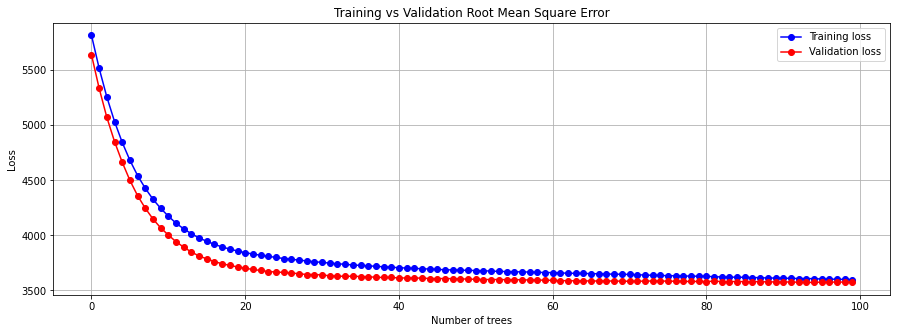

In [8]:
model, results, x_test, y_test = evaluate(x, y, random_state=42)

plt.figure(figsize=(15,5))
plt.title('Training vs Validation Root Mean Square Error')
plt.plot(results["validation_0"]["rmse"], "bo-", label="Training loss")
plt.plot(results["validation_1"]["rmse"], "ro-", label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Resultado final

O modelo obteve um erro médio absoluto de aproximadamente 1800 habitantes, o que considero um erro moderado para uma prova de conceito.

In [9]:
mean_absolute_error(y_test, model.predict(x_test)).round(2)

1891.13

O resíduo demonstra a existencia de Outliers e a provavel necessidade de novas características para melhor compreensão dos padrões estudados

In [10]:
y_pred = model.predict(x_test).astype('int64')

result = pd.DataFrame({
    'y_true': y_test, 
    'y_pred': y_pred, 
    'residue': y_pred - y_test
})

px.histogram(result, 'residue', title='Distribuição dos resíduos do modelo')

## Os resíduos que estão afastados do valor 0 podem ser explicados pelos outliers, como pode ser visto no gráfico abaixo

No gráfico, os pontos representam os outliers e as caixas o intervalo que contêm a maioria dos valores de população sem acesso à internet.

In [11]:
px.box(
    data[data.error_range_95 <= .15], 
    'st', 
    'population_without_broadband', 
    title='Distribuição do Uso de Banda Larga por Estado'
).update_xaxes(categoryorder='total descending')

**IMPORTANTE** Se removermos o parâmetro **random_state** da função **evaluate** e excutar algumas vezes o treinamento, notará que as vezes o resultado final varia muito. Isso pode estar relacionado a um possível **Underfitting** do modelo.

In [12]:
model, results, x_test, y_test = evaluate(x, y)
mean_absolute_error(y_test, model.predict(x_test)).round(2)

1840.73